In [10]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import astropy.units as u

from config.plotting import save_figure, set_plotting_defaults, Tab10
from config.units import Gauss, flux_unit
from spectrum_fit_electrons import JointCooledSpectrumFit
from config.settings import MCMC_ELECTRONS_FULL, SPECTRUM_DIR
from src.synchrotron_emission import electron_synchrotron_emission_power, electron_synchrotron_emission_luminosity

set_plotting_defaults()

In [11]:
nsteps, nwalkers = 2000, 64
bvalue = 4e-6

data = pickle.load(open(os.path.join(MCMC_ELECTRONS_FULL, f"joint_{nsteps}n_{nwalkers}w_{bvalue * 1e6:.1f}uG.pck"), "rb"))

result, joint = data[0], data[1]

In [12]:
data = pickle.load(open(os.path.join(SPECTRUM_DIR, "UHE_spectrum_corrected.pck"), "rb"))

names, e, f_cor, f_l_cor, f_p_cor, e_l, e_p = data

In [13]:
result_mod = result[result[:, 1] > 2]
result_mod2 = result_mod# [abs(result_mod[:, 2] - 3.0) < 2.5]

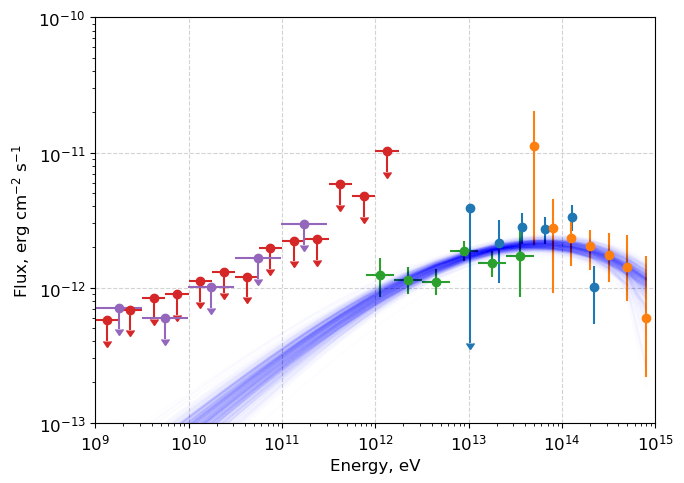

In [14]:
for i, name in enumerate(names):
    plt.errorbar(e[i], f_cor[i], xerr=[e_l[i], e_p[i]], yerr=[f_l_cor[i], f_p_cor[i]],
                 fmt='o', linestyle='None', uplims=f_p_cor[i] <= 0,
                 color=Tab10[i], label=f' ')

for res in result_mod2[::5]:
    plt.plot(joint.photon_energy, joint.model(res), alpha=.008, color='blue')

plt.xscale('log')
plt.xlim(1e9, 1e15)
plt.xlabel("Energy, eV")

plt.yscale('log')
plt.ylim(1e-13, 1e-10)
plt.ylabel(r"Flux, $\mathrm{erg~cm^{-2}~s^{-1}}$")
plt.tight_layout()
# save_figure(f"electron_fit_mcmc_{bvalue * 1e6:.1f}uG")
plt.show()

In [15]:
print(np.mean(result_mod2, axis=0))
k = np.argmax(result_mod2[:, 2])
print(f"{joint.times[9000]:.0f}")
print(result_mod2[k])
print(np.max(result_mod2, axis=0))
print(np.min(result_mod2, axis=0))

[1.21641815e+00 2.83325370e+00 4.24101431e+03]
39659 yr
[9.49422087e-01 2.65398242e+00 7.85786595e+03]
[1.94724266e+00 3.02200455e+00 7.85786595e+03]
[0.32993874 2.58507855 4.64767417]


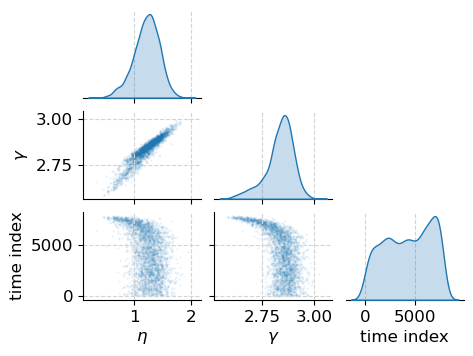

In [16]:
columns = [r"$\eta$", r"$\gamma$", r"time index"]
fs = pd.DataFrame(result_mod2, columns=columns)

g = sns.pairplot(fs, diag_kind="kde",
                plot_kws=dict(marker=".", linewidth=0, alpha=.1, s=10),
                corner=True, height=1.2, aspect=4/3)
# g.map_lower(sns.kdeplot, levels=5, color=".2", alpha=.3)
# save_figure(f"pairplot{nsteps}")
plt.show()

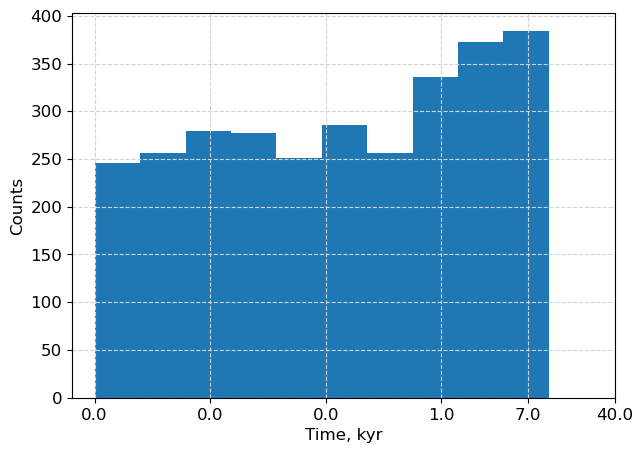

In [17]:
times = result_mod2[:, 2]
plt.hist(times)

plt.xticks([0, 2000, 4000, 6000, 7500, 9000], np.round(joint.times[[0, 2000, 4000, 6000, 7500, 9000]].value / 1000))
plt.xlabel(r"Time, kyr")
plt.ylabel(r"Counts")
plt.show()

In [18]:
from analysis.general_spectrum_analysis import volume_approximation

# calculate the synchrotron_emission
bfield = bvalue * Gauss
synch_photon_energy = np.logspace(-8, 15, 100) * u.eV

result_chosen = result_mod2[::500]
synch_flux1 = np.zeros([result_chosen.shape[0], synch_photon_energy.size]) * flux_unit
synch_flux5 = np.zeros([result_chosen.shape[0], synch_photon_energy.size]) * flux_unit
e_volume = volume_approximation(joint.electron_energy)

for i, res_i in enumerate(result_chosen):
    print(i, end=' ')
    e_density = joint.cooled_spectrum(res_i)
    synch_rad1 = electron_synchrotron_emission_luminosity(joint.electron_energy, e_density, e_volume,
                                                          synch_photon_energy, bfield)
    synch_flux1[i] = synch_rad1 * synch_photon_energy / joint.area

0 1 2 3 4 5 

In [19]:
from spectrum.measurements_xray import constraint_XRISM, constraint_Chandra

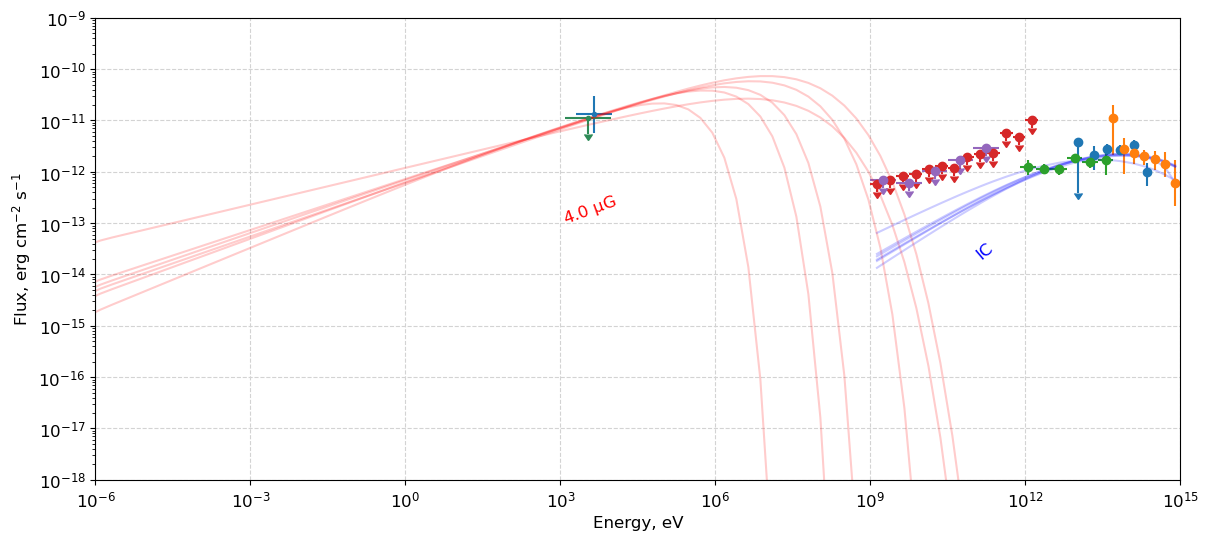

In [20]:
plt.figure(figsize=(14, 6))
for i, name in enumerate(names):
    plt.errorbar(e[i], f_cor[i], xerr=[e_l[i], e_p[i]], yerr=[f_l_cor[i], f_p_cor[i]],
                 fmt='o', linestyle='None', uplims=f_p_cor[i] <= 0,
                 color=Tab10[i], label=f' ')

e, f, f_l, f_p, e_l, e_p = constraint_XRISM()
plt.errorbar(e, f, xerr=[e_l, e_p], yerr=[f_l, f_p],
             marker='o', markersize=3, label='XRISM, 2025', linestyle='None')

e, f, f_l, f_p, e_l, e_p = constraint_Chandra()
plt.errorbar(e, f, xerr=[e_l, e_p], yerr=0.5 * f, uplims=True,
             marker='o', markersize=3, label='XRISM, 2025', linestyle='None', color='seagreen')

for i, res in enumerate(result_chosen):
    # plot gamma-ray spectrum
    plt.plot(joint.photon_energy, joint.model(res), alpha=.2, color='blue')
    # plot synchrotron spectrum
    plt.plot(synch_photon_energy, synch_flux1[i], alpha=.2, color='red')

plt.text(1e3, 1e-13, f'{bvalue * 1e6:.1f} 'r'$\mathrm{\mu G}$', color='red', rotation=20)
plt.text(1e11, 2e-14, 'IC', color='blue', rotation=40)

plt.xscale('log')
plt.xlim(1e-6, 1e15)
plt.xlabel("Energy, eV")

plt.yscale('log')
plt.ylim(1e-18, 1e-9)
plt.ylabel(r"Flux, $\mathrm{erg~cm^{-2}~s^{-1}}$")
plt.show()